# 量子卫星定位

该量子算法探讨了将一组卫星最佳分组为星座以观察地球上特定目标的问题。每颗卫星都具有独特的观测能力，影响其在一定时间内监测指定区域的有效性。该算法的目标是展示如何最大化每个星座的地球覆盖范围的量子优势，确保尽可能有效地监控所有目标。

In [2]:
import itertools
import json
import math
import sys
import matplotlib.pyplot as plt
import dimod
import dynex
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## 辅助函数

In [4]:
def calculate_score(constellation, data):
    """计算卫星分数的函数。"""

    score = 1
    for v in constellation:
        score *= (1 - data['coverage'][str(v)])
    score = 1 - score
    return score

In [5]:
def build_bqm(data, constellation_size):
    """构建问题bqm。"""

    # 不考虑平均分数低于score_threshold的卫星
    score_threshold = .4

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # 首先我们想要支持高分组合
    for constellation in itertools.combinations(range(data['num_satellites']), constellation_size):
        # 该分数是星座中至少一颗卫星在任何时刻具有目标视线的概率。
        score = calculate_score(constellation, data)

        # 为了使它更小，丢弃分数低于的组合
        # 设定的阈值
        if score < score_threshold:
            continue

        # 我们减去分数是因为我们想最小化能量
        bqm.add_variable(frozenset(constellation), -score)

    # 接下来我们要惩罚共享卫星的配对。我们选择2是因为
    # 不希望出现在这种情况下可以同时选择两者
    # 确保都是 100% 的覆盖率
    for c0, c1 in itertools.combinations(bqm.variables, 2):
        if c0.isdisjoint(c1):
            continue
        bqm.add_interaction(c0, c1, 2)

    # 最后我们希望选择 num_constellations 变量。我们选择强度为1
    # 因为我们不希望违反约束条件是有利的
    # 选择更多变量
    bqm.update(dimod.generators.combinations(bqm.variables, data['num_constellations'], strength=1))

    return bqm

In [167]:
def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)

def viz(constellations, data):
    """ 可视化解决方案"""
    
    angle = 2*math.pi / data["num_satellites"]
    plt.figure(figsize=(10,6))
    img = plt.imread("satellite-data/earth.jpg")
    
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:black')
    
    plt.title('Optimal Satellite Constellations\n'+str(data['num_satellites'])+' satellites, '+str(data['num_constellations'])+' targets to observe', color='white')
    plt.imshow(img, zorder=0, extent=[-1.5, 1.5, -1, 1])
    
    s = 0
    for c in constellations:
        x = []
        y = []
        label = []
        for satellite in c:
            coverage = 1 - data["coverage"][str(satellite)]
            label.append(satellite)
            x.append(coverage*math.cos(s*angle))
            y.append(coverage*math.sin(s*angle)+0.2)
            s += 1
    
        x.append(x[0])
        y.append(y[0])
        label.append(label[0])
        plt.plot(x, y, zorder=1, marker = 'o', markersize=10, color='white')
    plt.tight_layout()
    plt.axis('off')
    plt.show()

## 量子解决方案

In [52]:
with open('satellite-data/mini.json', 'r') as fp:
    data = json.load(fp)

In [53]:
print('Number of satellites:',data['num_satellites']);
print('Number of targets on earth to observe:',data['num_constellations']);

Number of satellites: 9
Number of targets on earth to observe: 3


In [54]:
# 每颗 x 卫星（标记为 0..n-1）都有一个覆盖分数。这可能是
# 计算为地球区域处于范围内的时间百分比
# 卫星

constellation_size = data['num_satellites'] // data['num_constellations']

bqm = build_bqm(data, constellation_size)

In [55]:
sampleset = dynex.sample(bqm, mainnet=False, num_reads=10000, annealing_time = 1000, description='Satellite Positioning');
print(sampleset)

[DYNEX] PRECISION SET TO 0.0001
[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬───────────────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │ ELAPSED   │ WORKERS READ              │ CIRCUITS   │ STEPS   │ GROUND STATE   │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼───────────────────────────┼────────────┼─────────┼────────────────┤
│         -1 │       92 │            3578 │           0 │           │ *** WAITING FOR READS *** │            │         │                │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴───────────────────────────┴────────────┴─────────┴────────────────╯

[DYNEX] FINISHED READ AFTER 0.40 SECONDS
[DYNEX] SAMPLESET READY
  frozenset({0, 1, 2}) ... frozenset({8, 6, 7})    energy num_oc.
0                    0 ...                    0 -2.922514       1
['BINARY',

Constellation: frozenset({0, 1, 5}), Score: 0.97568
Constellation: frozenset({2, 4, 6}), Score: 0.973666
Constellation: frozenset({8, 3, 7}), Score: 0.973168
Total Score: 2.922514
Normalized Score (tot / # constellations): 0.9741713333333334


<Figure size 1000x600 with 0 Axes>

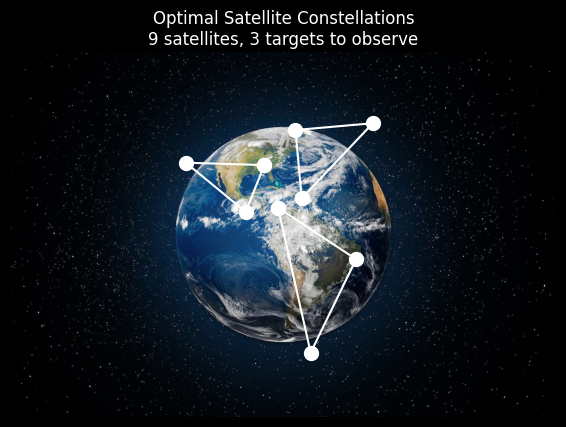

In [168]:
constellations = [constellation
                for constellation, chosen in sampleset.first.sample.items()
                if chosen]

tot = 0
for constellation in constellations:
    score = calculate_score(constellation, data)
    print("Constellation: " + str(constellation) + ", Score: " + str(score))
    tot += score
print("Total Score: " + str(tot))
print("Normalized Score (tot / # constellations): " + str((tot / data['num_constellations'])))

viz(constellations, data)